In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "True"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from matplotlib import animation
from matplotlib import gridspec
from IPython.display import HTML

import gpflow
from gpflow.kernels import SquaredExponential, Periodic
from gpflow.models import GPR
from gpflow.optimizers import Scipy
from gpflow.utilities import multiple_assign, read_values
from tools.datasets import load_data
from tools.plotting import plot_1d_model

In [3]:
d = load_data("periodic1d")
X, Y = d.X, d.Y
sort = np.argsort(X.flatten())
X = X[sort, :]
Y = Y[sort, :]
pX = np.linspace(-5, 5, 3000)[:, None]

# Marginal Likelihood
Let's take a look at how the marignal likelihood helps with model selection. These illustrations were discussed in my [GenU 2021](https://genu.ai) [talk](https://mvdw.uk/talk/input-densities-and-predictive-uncertainties/).

If the videos don't show in GitHub, try using [NBviewer](https://nbviewer.org/github/markvdw/inference-plots/blob/main/marginal-likelihood.ipynb) instead.

##  1 Optimising Hyperparameters

###  1.1 Squared Error
Let's try to find hyperparmaters by minimising some measure of fit to the training data. Let's start with the common mean squared error.

In [4]:
class GPR_mse(GPR):
    def maximum_log_likelihood_objective(self) -> tf.Tensor:
        return -tf.reduce_mean((self.predict_y(self.data[0])[0] - self.data[1]) ** 2.0)
    
class GPR_lpd(GPR):
    def maximum_log_likelihood_objective(self) -> tf.Tensor:
        return tf.reduce_sum(self.predict_log_density(self.data))

def animate_training(mm, plot_var=None, iterations=None, iterations_per_frame=None, learning_rate=None):
    learning_rate = 0.01 if learning_rate is None else learning_rate
    if isinstance(mm, GPR_mse):
        iterations, iterations_per_frame = 10000, 150
    elif isinstance(mm, GPR_lpd):
        iterations, iterations_per_frame = 1600, 30
        plot_var = True
    else:
        if not iterations or not iterations_per_frame:
            raise NotImplemented()

    fig = plt.figure(constrained_layout=True, figsize=(8, 4.8))
    spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
    ax_m, ax_loss, ax_hyp = [fig.add_subplot(s) for s in [spec[0, :], spec[1, 0], spec[1, 1]]]
    ax_m.set_xlabel("regression input")
    ax_m.set_ylabel("regression target")

    ax_m.plot(X, Y, 'x')
    pY, pYv = mm.predict_y(pX)
    line_mean, = ax_m.plot(pX, pY.numpy())
    if plot_var:
        ax_m.fill_between(pX.flatten(),
                          (pY - 2 * pYv ** 0.5).numpy().flatten(),
                          (pY + 2 * pYv ** 0.5).numpy().flatten(),
                        alpha=0.3, label="2$\sigma$ func" if plot_var == "f" else "2$\sigma$ data")

    ax_loss.set_xlim(0, iterations)
    if type(mm) is GPR_lpd:
        ax_loss.set_ylim(-50, 200)
    elif type(mm) is GPR:
        ax_loss.set_ylim(-50, 10)
    line_loss, = ax_loss.plot([], [])
    ax_loss.set_xlabel("iteration")
    ax_loss.set_ylabel("training loss")

    ax_hyp.set_xlim(0.001, 1.1)
    ax_hyp.set_ylim(0.001, 1.1)
    if type(mm.kernel) is SquaredExponential:
        line_hyp, = ax_hyp.plot([mm.kernel.lengthscales.numpy()], [mm.likelihood.variance.numpy() ** 0.5])
    ax_hyp.set_xlabel("lengthscale")
    ax_hyp.set_ylabel("noise stddev")
    ax_hyp.set_xscale('log'); ax_hyp.set_yscale('log')

    logstep = []
    logf = []
    loghyp = []
    training_loss = mm.training_loss_closure(compile=True)
    optimizer = Adam(learning_rate=learning_rate)
    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, mm.trainable_variables)

    def drawframe(step):
        print(step, end=" ")
        if step > 0:
            for _ in range(iterations_per_frame):
                optimization_step()
        elbo = -training_loss().numpy()
        logf.append(elbo)
        logstep.append(step * iterations_per_frame)
        if type(mm.kernel) is SquaredExponential:
            loghyp.append((mm.kernel.lengthscales.numpy(), mm.likelihood.variance.numpy() ** 0.5))

        pY, pYv = mm.predict_y(pX)
        line_mean.set_data(pX, pY.numpy())
        # ax_m.collections.clear()
        if plot_var:
            ax_m.fill_between(pX.flatten(),
                              (pY - 2 * pYv ** 0.5).numpy().flatten(),
                              (pY + 2 * pYv ** 0.5).numpy().flatten(),
                              color='C0',
                              alpha=0.3, label="2$\sigma$ func" if plot_var == "f" else "2$\sigma$ data")
        
        line_loss.set_data(logstep, logf)
        if type(mm.kernel) is SquaredExponential:
            line_hyp.set_data(np.array(loghyp)[:, 0], np.array(loghyp)[:, 1])
        return line_mean, line_loss

    anim = animation.FuncAnimation(fig, drawframe, frames=iterations // iterations_per_frame, interval=100, blit=True)
    print(f"frames: {iterations // iterations_per_frame}")
    return fig, anim

In [5]:
m_mse = GPR_mse((X, Y), SquaredExponential())
fig, anim = animate_training(m_mse)
plt.close(fig)
HTML(anim.to_html5_video())

0 0 frames: 66
0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 

We see we obtain a solution that drastically overfits. By making the lengthscale and observation noise very small, we can interpolate every datapoint. However, this doesn't help with extrapolation!

(Short note: It would be interesting to investigate a bit further how overparameterisation helps in this case. I suspect that it will reduce the overfitting behaviour, but that the training loss will still not be sufficient for learning good inductive biases.)

### 1.2 Does Uncertainty Help?
Often, it is said that doing Bayesian inference helps against overfitting. Here, we find the exact posterior, and minimise the log predictive density w.r.t. the hyperparameters.

In [6]:
m_lpd = GPR_lpd((X, Y), SquaredExponential())
fig, anim = animate_training(m_lpd)
plt.close(fig)
HTML(anim.to_html5_video())

0 0 frames: 53
0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 

### 1.3 Optimising the Marginal Likelihod

In [7]:
m = GPR((X, Y), SquaredExponential())
# We can't quite initialise at the poor solution we found earlier, due to local minima.
# But we can initialise quite nearby!
m.kernel.lengthscales.assign(1e-2)
m.likelihood.variance.assign(3.2e-2 ** 2.0)
fig, anim = animate_training(m, iterations=700, iterations_per_frame=10, learning_rate=0.01, plot_var=True)
plt.close(fig)
HTML(anim.to_html5_video())

0 0 frames: 70
0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 

In [8]:
mper = GPR((X, Y), SquaredExponential() + Periodic(SquaredExponential()))
mper.kernel.kernels[0].lengthscales.assign(1e-2)
mper.kernel.kernels[1].base_kernel.variance.assign(1e-2)
mper.likelihood.variance.assign(3.2e-2 ** 2.0)
fig, anim = animate_training(mper, iterations=700, iterations_per_frame=10, learning_rate=0.01, plot_var=True)
plt.close(fig)
HTML(anim.to_html5_video())

0 0 frames: 70
0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 

## 2 Why does the marginal likelihood work?

In [9]:
dss = load_data("periodic1d-subset")
Xss, Yss = dss.X, dss.Y
sort = np.argsort(Xss.flatten())
Xss = Xss[sort, :]
Yss = Yss[sort, :]

In [10]:
def animate_acc(m_list):
    fig, ax_list = plt.subplots(len(m_list) + 1, 1, figsize=(8, 4.8 / 2 * (len(m_list) + 1)))
    ax_m_list = ax_list[:-1]
    ax_m_list[-1].set_xlabel("regression input")
    [ax.set_ylabel('regression target') for ax in ax_m_list]
    ax_acc = ax_list[-1]
    ax_acc.set_xlabel("Number of datapoints seen")
    ax_acc.set_ylabel("Log marginal likelihood")

    line_means = []
    line_datas = []
    texts = []
    next_markers = []
    for mm, ax_m in zip(m_list, ax_m_list):
        pY, pYv = mm.predict_y(pX)
        line_means.append(ax_m.plot(pX, pY.numpy())[0])
        line_datas.append(ax_m.plot([], [], 'o')[0])
        next_markers.append(ax_m.plot([], [], 'o', color='C3', mfc='none', markersize=10)[0])
        texts.append(ax_m.text(0, 0, ""))
        ax_m.plot(Xss, Yss, 'x')
        ax_m.fill_between(pX.flatten(),
                          (pY - 2 * pYv ** 0.5).numpy().flatten(),
                          (pY + 2 * pYv ** 0.5).numpy().flatten(),
                          alpha=0.3, label="2$\sigma$ data")
        # ax_m.autoscale(False)
        # ax_m.set_ylim(-2.0, 2.0)
        ax_m.set_xlim(-1.6, 1.6)
    line_accs = ax_acc.plot([0], [[0, 0, 0]])
    ax_acc.set_xlim(0, len(Xss))
    ax_acc.set_ylim(-50, 0)
    # title = ax_m_list[0].set_title("abc")
    plt.tight_layout()

    lpds_step_m = []
    def drawframe(step):
        print(step, end=" ")

        mode = step % 2
        i = step // 2

        lpds_m = []
        for mm, ax_m, lm, ld, text, mrkr in zip(m_list, ax_m_list, line_means, line_datas, texts, next_markers):
            if i > 0:
                mm.data = gpflow.models.util.data_input_to_tensor((Xss[:i, :], Yss[:i, :]))
                pY, pYv = mm.predict_y(pX)
            else:
                pY, pYv = mm.predict_y(pX)
                pYv = np.ones((len(pYv.numpy()), 1)) * pYv.numpy().max()
            ax_m.collections.clear()
            ax_m.fill_between(pX.flatten(),
                              (pY - 2 * pYv ** 0.5).numpy().flatten(),
                              (pY + 2 * pYv ** 0.5).numpy().flatten(),
                              color='C0',
                              alpha=0.3, label="2$\sigma$ data")
            lm.set_data(pX, pY.numpy())
            ax_m.plot(mm.data[0], mm.data[1], 'o', color='C1')

            if mode == 1:
                pred_mean, pred_var = [t.numpy()[0, 0] for t in mm.predict_y(Xss[i:i + 1, :])] if i > 0 else (0.0, pYv[0, 0])
                lpd = - 0.5 * (Yss[i, 0] - pred_mean) ** 2.0 / pred_var - 0.5 * np.log(2 * np.pi * pred_var)
                lpds_m.append(lpd)
                mrkr.set_data(Xss[i:i + 1, :], Yss[i:i + 1, :])
                text.set_text(f"lpd: {lpd:.2f}")
                text.set_position((Xss[i, 0] + 0.03, Yss[i, 0] + 0.03))
            else:
                text.set_text("")
                mrkr.set_data([], [])

        if mode == 1:
            lpds_step_m.append(lpds_m)
            lpds_np = np.array(lpds_step_m)
            # print(lpds_np)
            [la.set_data(np.arange(len(lpds_np)), np.cumsum(d)) for la, d in zip(line_accs, lpds_np.T)]

        return line_means + line_datas

    anim = animation.FuncAnimation(fig, drawframe, frames=len(Xss) * 2, interval=1000, blit=True)
    return fig, anim

0 

AttributeError: 'ArtistList' object has no attribute 'clear'

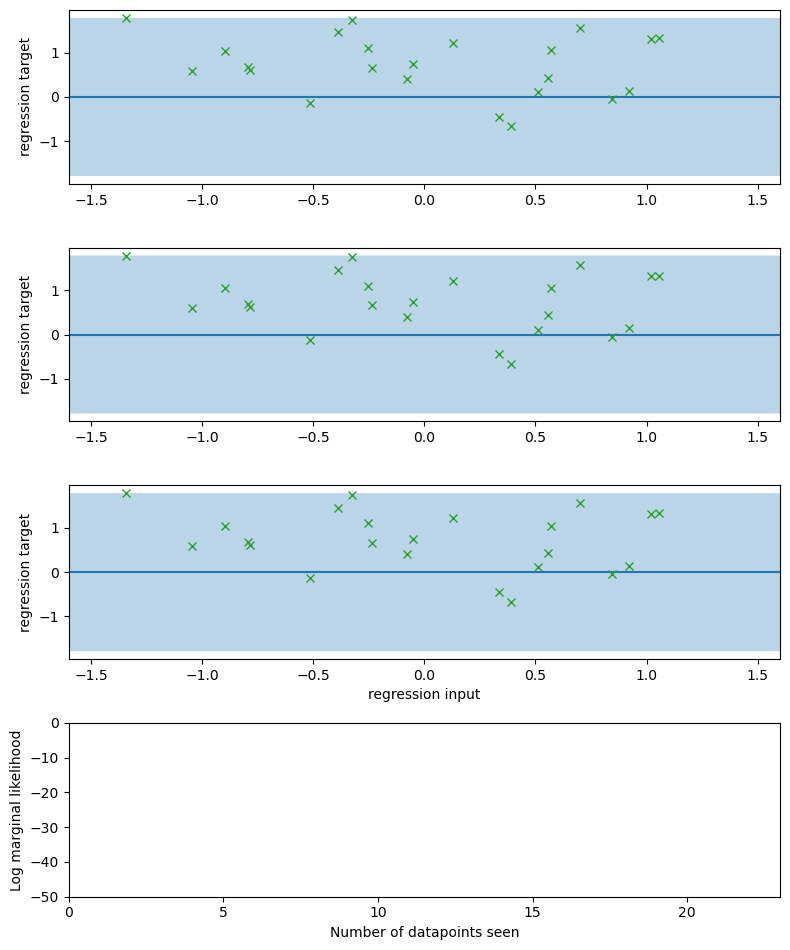

In [11]:
opt_hypers = read_values(m)
m_list = [GPR((np.array([[-100.0]]), np.array([[0.0]])), SquaredExponential()) for _ in range(3)]
m_short, m_opt, m_long = m_list
for mm, ls_factor in ((m_short, 0.1), (m_opt, 1.0), (m_long, 2.5)):
    multiple_assign(mm, opt_hypers)
    mm.kernel.lengthscales.assign(mm.kernel.lengthscales.numpy() * ls_factor)
fig, anim = animate_acc(m_list)
plt.close(fig)
HTML(anim.to_html5_video())

In [11]:
m_list = [GPR((np.array([[-100.0]]), np.array([[0.0]])), SquaredExponential() + Periodic(SquaredExponential())),
          GPR((np.array([[-100.0]]), np.array([[0.0]])), SquaredExponential())]
multiple_assign(m_list[0], read_values(mper))
multiple_assign(m_list[1], opt_hypers)
fig, anim = animate_acc(m_list)
plt.close(fig)
HTML(anim.to_html5_video())

0 0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 